<a href="https://colab.research.google.com/github/seismosmsr/hawaii_soils/blob/main/Hawaii_Soils_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
install.packages('sf')
install.packages('raster')
install.packages('exactextractr')
install.packages("googledrive")
install.packages("googletoken")
install.packages("DBI")
install.packages("RSQLite")
install.packages("RPostgreSQL")
install.packages("terra")
install.packages('randomForest')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘Rcpp’, ‘s2’, ‘units’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘googletoken’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the

In [3]:
library(ggplot2)
library(sf)
library(magrittr)
library(data.table)
library(raster)
library(exactextractr)
library(googledrive)
library(DBI)
library(terra)
library(randomForest)
library(parallel)

Linking to GEOS 3.10.2, GDAL 3.4.3, PROJ 8.2.1; sf_use_s2() is TRUE

Loading required package: sp

terra 1.7.55


Attaching package: ‘terra’


The following object is masked from ‘package:data.table’:

    shift


The following objects are masked from ‘package:magrittr’:

    extract, inset


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




In [4]:
while(TRUE){}

In [5]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=1c689b3c07bb59835415a6b6eb4e37f6&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYa0FkcmkySG1SU2lYaUViWEdZWmxrWVQySThNSld0cHBDTGtNeUhUMndRdW85VGNzZHZyOVpfX3BZdF9ab0NuUSIsInN0YXRlIjoiMWM2ODliM2MwN2JiNTk4MzU0MTVhNmI2ZWI0ZTM3ZjYifQ==


In [6]:
# https://drive.google.com/file/d/1ryTzWz0t9mgI5ynPvMzM21D135dLJvWv/view?usp=drive_link
# Updated: https://drive.google.com/file/d/17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C/view?usp=sharing
drive_download(as_id('17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C'), path = paste0('/content/fia.csv'), overwrite = TRUE)
fia_dt <-  st_read('/content/fia.csv') %>% st_as_sf(coords = c("LON","LAT"), crs = 4326) %>% data.table

File downloaded:

• 2023_11_01FIA_soil_subset.csv <id: 17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C>

Saved locally as:

• /content/fia.csv



Reading layer `fia' from data source `/content/fia.csv' using driver `CSV'


Warning message:
“no simple feature geometries present: returning a data.frame or tbl_df”


In [ ]:
# fia_dt %>% st_as_sf %>% st_write('fia.gpkg')

In [8]:
# https://drive.google.com/file/d/1LZQIykiIRmkIv-Ygy24rAN1ohmGOG1rY/view?usp=drive_link
drive_download(as_id('1LZQIykiIRmkIv-Ygy24rAN1ohmGOG1rY'), path = "/content/250_summary_grid_dt.gpkg", overwrite = TRUE)
grid_dt <- st_read("/content/250_summary_grid_dt.gpkg") %>% st_transform(4326) %>% data.table()

File downloaded:

• 250_summary_grid_dt.gpkg <id: 1LZQIykiIRmkIv-Ygy24rAN1ohmGOG1rY>

Saved locally as:

• /content/250_summary_grid_dt.gpkg



Reading layer `250_summary_grid_dt' from data source 
  `/content/250_summary_grid_dt.gpkg' using driver `GPKG'
Simple feature collection with 227561 features and 38 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 57161.36 ymin: 16952.32 xmax: 572661.4 ymax: 381202.3
Projected CRS: NAD_1983_HARN_StatePlane_Hawaii_1_FIPS_5101


In [9]:
# Simulation data
# https://drive.google.com/file/d/1bk1A8XJn46VJ0CIlbjgdZHvvlII4F7FC/view?usp=drive_link
drive_download(file = as_id('1bk1A8XJn46VJ0CIlbjgdZHvvlII4F7FC'), path =  '/content/sim_results_Hawaii_Run1.gpkg', overwrite = TRUE)

# # # # https://drive.google.com/file/d/1ShQ40eYKzUx-geZfm4lTz_YezZRG9qGe/view?usp=drive_link Run 2
# drive_download(file = as_id('1ShQ40eYKzUx-geZfm4lTz_YezZRG9qGe'), path =  '/content/sim_results_Hawaii_Run2.gpkg', overwrite = TRUE)

# # # # https://drive.google.com/file/d/1Zr13S1PI2Z782At36qZcCPokYpSCjZNW/view?usp=drive_link Run 3
# drive_download(file = as_id('1Zr13S1PI2Z782At36qZcCPokYpSCjZNW'), path =  '/content/sim_results_Hawaii_Run3.gpkg', overwrite = TRUE)


File downloaded:

• sim_results_Hawaii_10000m_v4_Run1.gpkg
  <id: 1bk1A8XJn46VJ0CIlbjgdZHvvlII4F7FC>

Saved locally as:

• /content/sim_results_Hawaii_Run1.gpkg



In [10]:
sim_dt <- NULL
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3644349,194.7,9116741,486.9,9116741,486.9
Vcells,14390017,109.8,47369250,361.4,45748074,349.1


In [11]:
sim_1_dt <- st_read( '/content/sim_results_Hawaii_Run1.gpkg') %>% data.table
# sim_2_dt <- st_read( '/content/sim_results_Hawaii_Run2.gpkg') %>% data.table
# sim_3_dt <- st_read( '/content/sim_results_Hawaii_Run3.gpkg') %>% data.table

Reading layer `sim_results_Hawaii_10000m_v4_Run1' from data source 
  `/content/sim_results_Hawaii_Run1.gpkg' using driver `GPKG'
Simple feature collection with 3170000 features and 80 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -156.0017 ymin: 19.0045 xmax: -154.8362 ymax: 20.25088
Geodetic CRS:  WGS 84


In [ ]:
sim_1_dt$sim_id <- sim_1_dt$sim_id + 100000
# sim_2_dt$sim_id <- sim_2_dt$sim_id + 200000
# sim_3_dt$sim_id <- sim_3_dt$sim_id + 300000

In [13]:
print(sim_dt$sim_id %>% unique %>% length)

[1] 10000


In [12]:
sim_dt <-list(sim_1_dt ) %>% rbindlist()

In [14]:
sim_1_dt <- NULL
sim_2_dt <- NULL
sim_3_dt <- NULL

In [15]:
grid_int_dt  <- fia_dt$geom %>% st_transform(4135) %>% st_buffer(10000) %>% st_transform(4326) %>% st_intersects(grid_dt$geom)

In [16]:
rm_vec <- grid_int_dt %>% lapply(length) %>% unlist > 0
grid_int_dt <- grid_int_dt[rm_vec]
fia_dt <- fia_dt[rm_vec,]

In [17]:
grid_dt <- grid_dt[!is.na(srad),]

In [18]:
grid_dt$agbd_n <- grid_dt$agbd_n %>% as.numeric

In [19]:
fia_dt$Stock_SOC_Mg_Ha <- fia_dt$Stock_SOC_Mg_Ha %>% as.numeric

Warning message in fia_dt$Stock_SOC_Mg_Ha %>% as.numeric:
“NAs introduced by coercion”


In [20]:
names(sim_dt)[43]

[1] "predicted"

In [21]:
names(sim_dt)

[1] "PLOT"                       "SOC_Mg_Ha"                 
 [3] "DEPTH_UPPER"                "DEPTH_LOWER"               
 [5] "county_name"                "id"                        
 [7] "left"                       "top"                       
 [9] "right"                      "bottom"                    
[11] "water"                      "trees"                     
[13] "grass"                      "flooded_vegetation"        
[15] "crops"                      "shrub_and_scrub"           
[17] "built"                      "bare"                      
[19] "snow_and_ice"               "elevation"                 
[21] "landform"                   "SRTM_mTPI"                 
[23] "aet"                        "def"                       
[25] "pdsi"                       "pet"                       
[27] "pr"                         "ro"                        
[29] "soil"                       "srad"                      
[31] "swe"                        "tmmn"                      
[33] "tmmx"                       "vap"                       
[35] "vpd"                        "vs"                        
[37] "agbd_m"                     "agbd_sd"                   
[39] "agbd_n"                     "majorcomposition"          
[41] "age_years"                  "Age_Class"                 
[43] "predicted"                  "var_imp_DEPTH_UPPER"       
[45] "var_imp_DEPTH_LOWER"        "var_imp_water"             
[47] "var_imp_trees"              "var_imp_grass"             
[49] "var_imp_flooded_vegetation" "var_imp_crops"             
[51] "var_imp_shrub_and_scrub"    "var_imp_built"             
[53] "var_imp_bare"               "var_imp_snow_and_ice"      
[55] "var_imp_elevation"          "var_imp_landform"          
[57] "var_imp_SRTM_mTPI"          "var_imp_aet"               
[59] "var_imp_def"                "var_imp_pdsi"              
[61] "var_imp_pet"                "var_imp_pr"                
[63] "var_imp_ro"                 "var_imp_soil"              
[65] "var_imp_srad"               "var_imp_swe"               
[67] "var_imp_tmmn"               "var_imp_tmmx"              
[69] "var_imp_vap"                "var_imp_vpd"               
[71] "var_imp_vs"                 "var_imp_agbd_m"            
[73] "var_imp_agbd_sd"            "var_imp_agbd_n"            
[75] "var_imp_majorcomposition"   "var_imp_age_years"         
[77] "var_imp_Age_Class"          "r2_depth"                  
[79] "r2_plot"                    "sim_id"                    
[81] "geom"

In [24]:
names(sim_dt)[-c(2,4,5,43,78,80)]

[1] "PLOT"                       "SOC_Mg_Ha"                 
 [3] "DEPTH_UPPER"                "DEPTH_LOWER"               
 [5] "county_name"                "id"                        
 [7] "left"                       "top"                       
 [9] "right"                      "bottom"                    
[11] "water"                      "trees"                     
[13] "grass"                      "flooded_vegetation"        
[15] "crops"                      "shrub_and_scrub"           
[17] "built"                      "bare"                      
[19] "snow_and_ice"               "elevation"                 
[21] "landform"                   "SRTM_mTPI"                 
[23] "aet"                        "def"                       
[25] "pdsi"                       "pet"                       
[27] "pr"                         "ro"                        
[29] "soil"                       "srad"                      
[31] "swe"                        "tmmn"                      
[33] "tmmx"                       "vap"                       
[35] "vpd"                        "vs"                        
[37] "agbd_m"                     "agbd_sd"                   
[39] "agbd_n"                     "majorcomposition"          
[41] "age_years"                  "Age_Class"                 
[43] "predicted"                  "var_imp_DEPTH_UPPER"       
[45] "var_imp_DEPTH_LOWER"        "var_imp_water"             
[47] "var_imp_trees"              "var_imp_grass"             
[49] "var_imp_flooded_vegetation" "var_imp_crops"             
[51] "var_imp_shrub_and_scrub"    "var_imp_built"             
[53] "var_imp_bare"               "var_imp_snow_and_ice"      
[55] "var_imp_elevation"          "var_imp_landform"          
[57] "var_imp_SRTM_mTPI"          "var_imp_aet"               
[59] "var_imp_def"                "var_imp_pdsi"              
[61] "var_imp_pet"                "var_imp_pr"                
[63] "var_imp_ro"                 "var_imp_soil"              
[65] "var_imp_srad"               "var_imp_swe"               
[67] "var_imp_tmmn"               "var_imp_tmmx"              
[69] "var_imp_vap"                "var_imp_vpd"               
[71] "var_imp_vs"                 "var_imp_agbd_m"            
[73] "var_imp_agbd_sd"            "var_imp_agbd_n"            
[75] "var_imp_majorcomposition"   "var_imp_age_years"         
[77] "var_imp_Age_Class"          "r2_depth"                  
[79] "r2_plot"                    "sim_id"                    
[81] "geom"

In [32]:
remove_names <- c('SOC_Mg_Ha','DEPTH_UPPER','DEPTH_LOWER','predicted','geom') %>% match(names(sim_dt))
remove_names

[1]  2  3  4 43 81

In [33]:
sim_dt %>% nrow()
sim_no_depth_dt <- sim_dt[,names(sim_dt)[-c(remove_names)],with=FALSE] %>% unique
sim_no_depth_dt %>% nrow()

[1] 3170000

[1] 1120000

In [35]:
sim_no_depth_dt %>% nrow

[1] 1120000

In [36]:
sim_c_no_depth_dt <- sim_dt[,list(SOC_Mg_Ha=sum(SOC_Mg_Ha),predicted = sum(predicted),geom = unique(geom)),by = .(PLOT,sim_id)]
# sim_c_no_depth_dt <- sim_c_no_depth_dt %>% unique()

In [37]:
sim_c_no_depth_dt %>% nrow()

[1] 1120000

In [39]:
# (sim_no_depth_dt$PLOT %in% sim_c_no_depth_dt$PLOT & sim_no_depth_dt$sim_id %in% sim_c_no_depth_dt$sim_id ) %>% table

In [ ]:
# sim_c_no_depth_dt

In [40]:
sim_c_sum_dt <- merge(sim_c_no_depth_dt,sim_no_depth_dt,match = c('PLOT','sim_dt'))

In [42]:
# sim_c_sum_dt %>% names

In [43]:
sim_c_sum_dt[,z:=predicted-SOC_Mg_Ha]

In [44]:
sim_c_sum_dt[,rmse:=mean(((predicted-SOC_Mg_Ha))^2),by =.(PLOT,id)]

In [45]:
sim_c_sum_dt[,rmse_p:=mean(((predicted-SOC_Mg_Ha)/SOC_Mg_Ha)^2),by =.(PLOT,id)]

In [73]:
sim_c_sum_dt[rmse_p<.01,list(SOC_Mg_Ha = mean(SOC_Mg_Ha %>% as.numeric)),by = PLOT]$SOC_Mg_Ha %>% quantile(c(0,.2,.4,.6,.8,1))

0%       20%       40%       60%       80%      100% 
 33.56479  79.60925 139.69555 215.66964 287.10961 535.68869

In [55]:
sim_c_sum_dt

[1] 214

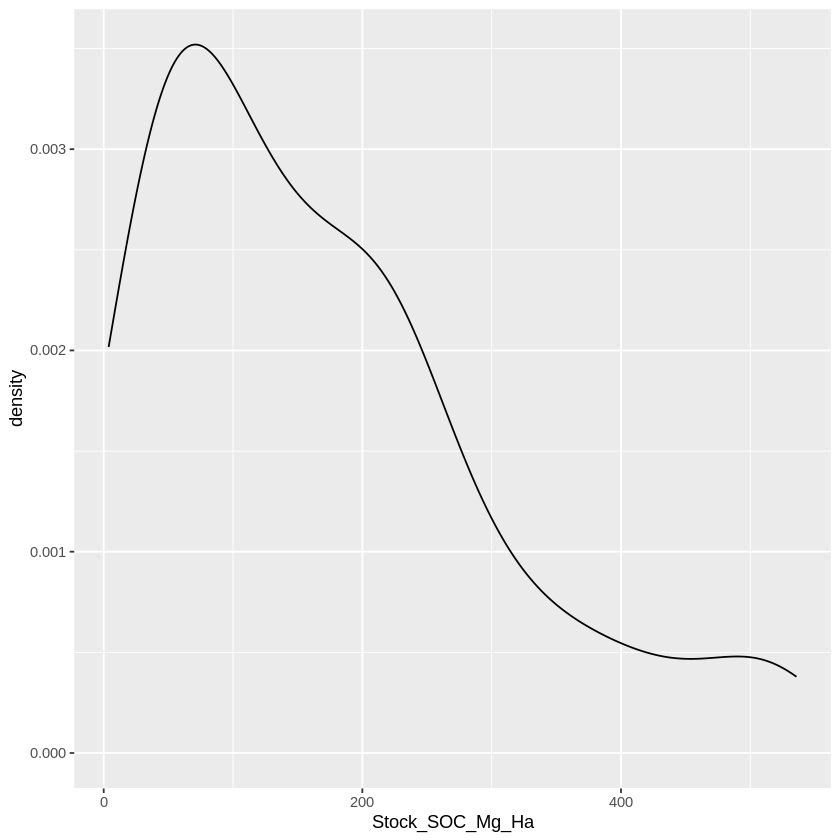

In [62]:
c[,list(Stock_SOC_Mg_Ha = mean(SOC_Mg_Ha %>% as.numeric)),by = PLOT] %>%
  ggplot(aes(x=Stock_SOC_Mg_Ha))+
  geom_density()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


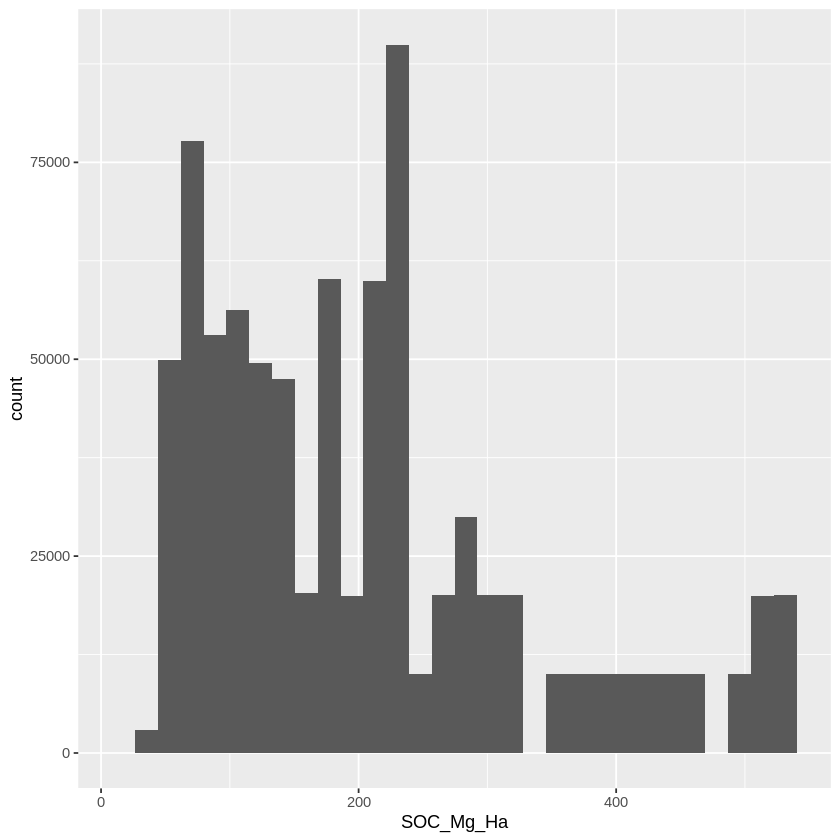

In [81]:
sim_c_sum_dt[rmse_p<.2] %>%
  ggplot(aes(x=SOC_Mg_Ha))+
  geom_histogram()

In [ ]:
# 175,250,325,475

In [95]:
head(sim_c_sum_dt)

PLOT,sim_id,SOC_Mg_Ha,predicted,geom,county_name,id,left,top,right,⋯,var_imp_age_years,var_imp_Age_Class,r2_depth,r2_plot,z,rmse,rmse_p,group_quantile,n_pred,n_pred_good
<chr>,<dbl>,<dbl>,<dbl>,<list>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<int>,<int>
2159,10001,421.2431,364.1446,"-155.73756, 20.13136",Hawaii,2559062,475161.4,143702.3,475411.4,⋯,18665.47,10068.701,0.2803563,0.8598157,-57.098492,1648.9386,0.009292637,"(325,475]",29,19
2159,10002,421.2431,365.7547,"-155.75431, 20.13812",Hawaii,2548538,473411.4,144452.3,473661.4,⋯,21419.57,8538.018,0.2511020,0.8431665,-55.488390,1186.6122,0.006687184,"(325,475]",17,17
2159,10003,421.2431,401.9281,"-155.72321, 20.12913",Hawaii,2568081,476661.4,143452.3,476911.4,⋯,20834.31,26425.264,0.2656619,0.8547523,-19.314940,2802.8906,0.015795763,"(325,475]",34,20
2159,10004,421.2431,396.3006,"-155.77358, 20.21939",Hawaii,2536478,471411.4,153452.3,471661.4,⋯,13683.13,12181.745,0.2773296,0.8420684,-24.942471,1205.0445,0.006791060,"(325,475]",13,13
2159,10005,421.2431,416.2800,"-155.73281, 20.15395",Hawaii,2562058,475661.4,146202.3,475911.4,⋯,19546.36,11710.814,0.2546325,0.8623375,-4.963105,742.3527,0.004183548,"(325,475]",25,21
2159,10006,421.2431,373.3085,"-155.72324, 20.14719",Hawaii,2568073,476661.4,145452.3,476911.4,⋯,24956.54,10585.007,0.2854975,0.8509950,-47.934564,1831.0951,0.010319184,"(325,475]",24,12


In [93]:
sim_c_sum_dt[,group_quantile:= cut(predicted, breaks = c(0,175,250,325,475,1000),include.lowest = T,ordered_result=T)]

In [88]:
sim_c_sum_dt[,n_pred := length(predicted),by=id]

In [89]:
sim_c_sum_dt[,n_pred_good := length(predicted[rmse_p<.2]),by=id]

In [98]:
sim_c_sum_dt[rmse_p<.2][,list(SOC_Mg_Ha = mean(predicted), pred = length(predicted),n_pred = mean(n_pred),n_pred_good = mean(n_pred_good),geom=unique(geom)),by=.(id,group_quantile)] %>% st_as_sf(crs='4326') %>% st_write('quantile_pred.gpkg',delete_dsn = T)

writing: substituting ENGCRS["Undefined Cartesian SRS with unknown unit"] for missing CRS



Deleting source `quantile_pred.gpkg' using driver `GPKG'
Writing layer `quantile_pred' to data source `quantile_pred.gpkg' using driver `GPKG'
Writing 119208 features with 6 fields and geometry type Point.


In [ ]:
quant_dt <- sim_c_sum_dt[rmse_p<.2][,list(SOC_Mg_Ha = mean(predicted),pred = length(predicted),total = mean(n_pred_good),geom=unique(geom)),by=.(id,group_quantile)]
quant_dt[,list(SOC_Mg_ha = sum(SOC_Mg_Ha*(pred/total)),geom = unique(geom)),by=id] %>% st_as_sf %>% st_write('sum_pred.gpkg',delete_dsn=T)

In [ ]:
sim_c_sum_dt[,list(count = length(PLOT %>% unique)),by = id]$count %>% qplot

In [ ]:
fia_dt[,list(SOC_Mg_Ha = sum(SOC_Mg_Ha %>% as.numeric)),by = PLOT]$SOC_Mg_Ha %>% qplot

In [ ]:
sim_c_sum_dt$rmse_p %>% qplot

In [ ]:
names(sim_c_sum_dt)[c(12:21, 23:40)]

In [ ]:
var_imp_dt <- sim_c_sum_dt[
  , .(r2 = lapply(.SD, function(x) {
          summary(lm(x ~ rmse_p, data = .SD))$r.squared
      }),
      variable = names(.SD)),
  by = .(PLOT),
  .SDcols = c(12:21, 23:40)
]

In [ ]:

var_imp_dt$r2 <-var_imp_dt$r2 %>% unlist

In [ ]:
# sim_c_sum_dt[id==2563556]

In [ ]:
sim_c_sum_dt[,min_plot:= PLOT[which.min(rmse_p)],by=id]

In [ ]:
# var_imp_dt[,list(imp_variable=variable[order(-r2)][1],r2=r2[order(-r2)][1]),by=PLOT]

In [ ]:
# sim_c_sum_dt$min_plot %>% qplot

In [ ]:
# sim_c_sum_dt$PLOT %>% table

In [ ]:
sim_c_sum_dt$imp_variable <- NULL
sim_c_sum_dt$r2 <- NULL

In [ ]:
 sim_c_sum_dt <- var_imp_dt[,list(imp_variable=variable[order(-r2)][1],r2=r2[order(-r2)][1]),by=PLOT] %>% merge(sim_c_sum_dt,.,by.x = 'min_plot',by.y = 'PLOT')

In [ ]:
sim_c_sum_dt %>% head

In [ ]:
# sim_c_sum_dt[,imp_variable:=imp_variable[order(-r2)][1],by=id]
# sim_c_sum_dt[,r2:=r2[order(-r2)][1],by=id]

In [ ]:
sim_c_sum_dt[rmse_p<.2][,list(rmse_p = mean(rmse_p),geom=geom[1]),by = .(id,imp_variable,r2)] %>% st_as_sf %>% st_write('variable_importance_id.gpkg',delete_dsn=T)

In [ ]:
# sim_c_sum_dt[rmse_p<.2] %>% st_as_sf %>% st_write('variable_importance.gpkg',delete_dsn)

In [ ]:
var_imp_dt$imp_variable %>% table

In [ ]:
var_imp_dt %>%
  ggplot(aes(x=r2))+
    geom_histogram(aes(fill=variable))+
    facet_wrap(variable~.,scales='free') +
    theme(legend.position = "none")


In [ ]:
r2_dt <-
sim_c_sum_dt$PLOT %>% unique %>%
  lapply(function(x){
  x_dt <- sim_c_sum_dt[PLOT == x]
  names(sim_c_sum_dt)[c(12:21, 23:40)] %>%
    lapply(function(y){
    r2 <-
    (lm(x_dt[['rmse_p']]~x_dt[[y]]) %>%
      summary())$r.squared
    data.table(PLOT = x,variable =y,r2 = r2) %>% return()
    }) %>% rbindlist
  }) %>% rbindlist


In [ ]:
r2_dt

In [ ]:
gc()

In [ ]:
cool_dt[PLOT == 2737] %>%
ggplot(aes(x=elevation,y=rmse_p))+
# ylim(0,1)+
geom_bin2d() +
geom_smooth(method='lm')

In [ ]:
sim_c_no_depth_dt[PLOT == 2737]$SOC_Mg_Ha %>% table

In [ ]:

(cool_dt[PLOT == 2822]  %>%
  lm(rmse_p~soil,.) %>%
  summary())$r.squared

In [ ]:
names(sim_c_sum_dt)

In [ ]:
# cool_dt <- sim_c_sum_dt[,list(rmse_p = mean(sqrt(z^2))/SOC_Mg_Ha,rmse = mean(sqrt(z^2)),var_imp_elevation = mean(var_imp_elevation) ,geom=unique(geom)[1],predicted = mean(predicted)),by = .(PLOT,id,soil,tmmn,vpd,SOC_Mg_Ha,trees,shrub_and_scrub,built,bare,aet,soil,vs,SRTM_mTPI,agbd_m,agbd_sd,elevation)]
# st_as_sf %>%
# st_write('review_output.gpkg',delete_dsn = T)
# cool_dt[,list(elev_r2= cor(elevation, SRTM_mTPI) ^ 2),by = .(PLOT)]
cool_dt[PLOT == 4102]  %>%
ggplot(aes(x=rmse_p,y=bare))+
# ylim(0,600)+
# geom_histogram()
geom_bin2d() +
geom_smooth(method='lm')

In [ ]:
sim_dt[,z:=(predicted-SOC_Mg_Ha)/SOC_Mg_Ha]

In [ ]:
sim_dt[,residual_per:=(predicted-SOC_Mg_Ha)/SOC_Mg_Ha]

In [ ]:
sim_dt[ z > -0.05 &z<0.05]$predicted %>% qplot

In [ ]:
sim_dt$SOC_Mg_Ha %>% qplot

In [ ]:
sim_dt[id==2831164]$predicted %>% qplot(bins=100)

sim_dt[id==2831164 & z > -0.05 &z<0.05]$predicted %>% qplot(geom='histogram')

In [ ]:
sim_summary_dt <- sim_dt[,list(length = length(r2),length_05 = length(r2[sqrt((z)^2) <0.05]),geom=unique(geom)),by=.(id,PLOT)]

In [ ]:
# sim_summary_dt
(sim_summary_dt[PLOT==5289]$length_05/sim_summary_dt[PLOT==5289]$length) %>% qplot

In [ ]:
sim_summary_dt %>% st_as_sf %>% st_write('sim_summary_id_plot.gpkg',delete_dsn = T)

In [ ]:
(sim_dt %>% names)[c(9:18,20:37)]

In [ ]:
sim_dt$id %>% sample(1)
sim_dt[id==2762315]$PLOT %>% table

In [ ]:
sim_dt[id==2762315] %>% nrow

In [ ]:
#  sim_dt[id==2762315 &PLOT == 2678]$z %>% abs %>% qplot

In [ ]:
sim_dt[id==2762315 &PLOT == 2678 ]$id %>% unique

In [ ]:
names(sim_dt)

In [ ]:
names(sim_dt)[c(11:42)]

In [ ]:
p_value_dt <-
sim_dt$PLOT %>% unique %>% lapply(function(y){
names(sim_dt)[c(9:18,20:37)] %>%
lapply(function(x){

  (cool_dt[PLOT == 2822]  %>%
  lm(rmse_p~soil,.) %>%
  summary())$r.squared
# # which_dt <- sim_dt[ PLOT == y ][,list(good = length(z[z < 0.05])/length(z) <0.02),by= .(PLOT,id)]
# good_x <- grid_dt[id %in% which_dt$id[which_dt$good]][[x]]
# bad_x <- grid_dt[id %in% which_dt$id[!which_dt$good]][[x]]
# if(length(good_x)>3 &length(bad_x)>3){
# p_value <- wilcox.test(good_x,bad_x)$p.value

# data.table(PLOT=y,variable=x,good = length(good_x),bad =length(bad_x),p_value=p_value) %>% return
# }else(return(data.table(PLOT=y,variable=x,good = length(good_x),bad =length(bad_x),p_value=NA)))
}) %>% rbindlist %>% return}) %>% rbindlist

In [ ]:
good_bad_dt <- p_value_dt[,list( mean(NA)),by=.(PLOT,good,bad)]

In [ ]:
good_bad_dt <- merge(fia_dt,good_bad_dt,by = 'PLOT')

In [ ]:
names(good_bad_dt)

In [ ]:
good_bad_dt %>%
  ggplot(aes(x=good/(bad +good),y=Stock_SOC_Mg_Ha %>% as.numeric))+
  geom_point() +
  facet_grid(Max_Lower_Depth %>% as.numeric~.)

In [ ]:
# x <- sim_dt[ PLOT == 2409 ][,list()]

z <- sim_dt[ PLOT == 2409 ]$z
length(x[abs(z) < 0.05])
length(x[abs(z) >= 0.05])
wilcox.test(sample(x[abs(z) < 0.05],500,replace=T) %>% sort ,
          sample(x[abs(z) >= 0.05],500,replace=T)%>% sort)

In [ ]:
x <- sim_dt[ PLOT == 2409 ]$elevation
z <- sim_dt[ PLOT == 2409 ]$z
t.test(x[abs(z) < 0.05],
          x[abs(z) >= 0.05])

In [ ]:
#  sim_dt[ PLOT == 2409 ] %>%
 data.table(elevation = c(sample(x[abs(z) < 0.05],1000000,replace=T),sample(x[abs(z) >= 0.05],1000000,replace=T)),z = c(rep(0,1000),rep(1,1000))) %>%
   ggplot(aes(x=elevation,group = abs(z) <0.05))+
     geom_density(aes(color= abs(z) <0.05))

In [ ]:


if(length(x[abs(z) < 0.05])>3 &length(x[abs(z) >= 0.05])>3 ){
  t.test(x[abs(z) < 0.05],
          x[abs(z) >= 0.05])$p.value
          }else(return(NA))

In [ ]:
qplot(x[abs(z) >= 0.05])

In [ ]:
qplot(x[abs(z) < 0.05])

In [ ]:
sim_dt[, good := length(z[abs(z) < 0.2])/length(z) > .50,by= .(PLOT,id,DEPTH_UPPER,DEPTH_LOWER)]

In [ ]:
sim_dt$good %>% table / nrow(sim_dt)

In [ ]:
sim_dt[,list(length=sum(good)),by= .(PLOT ,DEPTH_UPPER,DEPTH_LOWER)]

In [ ]:
names(sim_dt)[c(11:20,22:39)]

In [ ]:
sim_dt[,r2:=(lm(rmse_p~x ) %>% summary())$r.squared, by = .( PLOT )

In [ ]:
sim_dt %>% names

In [ ]:
var_imp_dt <- sim_dt[
  , .(r2 = lapply(.SD, function(x) {
          summary(lm(rmse_p ~ x, data = .SD))$r.squared
      }),
      variable = names(.SD)),
  by = .(PLOT),
  .SDcols = c(11:20, 22:39)
]

In [ ]:
 var_imp_dt<- sim_dt [
  , .(r2 = lapply(.SD, function(x) {

      (lm(rmse_p~x ) %>%
    summary())$r.squared


    }) ,
      variable = names(sim_dt)[c(11:20,22:39)])
  , by = .( PLOT )
  , .SDcols = c(c(11:20,22:39))
]

var_imp_dt$p_value <- var_imp_dt$r2 %>% unlist

In [ ]:
var_imp_dt$p_value%>%qplot

In [ ]:
# grid_dt

In [ ]:
# out_dt <- data.table(var_imp_dt,sim_summary_dt[match(var_imp_dt$id,sim_summary_dt$id)])
out_dt <- data.table(p_value_dt,fia_dt[,c('geometry')][match(p_value_dt$PLOT,fia_dt$PLOT)])

In [ ]:
out_dt[,bonferroni:=p_value*length(c(9:18,20:37))]

In [ ]:
out_dt$p_value <- out_dt$p_value %>% unlist

In [ ]:
# out_dt$geom <- NULL
out_dt

In [ ]:
# short_out_dt[!is.na(var_imp_aet),]

In [ ]:
short_out_dt <- dcast(out_dt,  PLOT ~ variable,value.var='bonferroni', drop=FALSE)
# short_out_dt <-short_out_dt[!is.na(trees),]

In [ ]:
short_out_dt

In [ ]:
good_set <- out_dt[,list(bonferroni_20 = mean(bonferroni[bonferroni<.2],na.rm=T),n=length(bonferroni[bonferroni<.2])),by = .(PLOT,variable)][!is.na(bonferroni_20)]$PLOT %>% unique

In [ ]:
good_set %>% length

In [ ]:
fia_dt[PLOT %in% good_set]$Stock_SOC_Mg_Ha %>% mean(na.rm=T)

In [ ]:
fia_dt %>%
  ggplot(aes(x=Stock_SOC_Mg_Ha))+
  geom_histogram()

In [ ]:
short_out_dt <- data.table(short_out_dt,fia_dt[,c('geometry')][match(short_out_dt$PLOT,fia_dt$PLOT)])

In [ ]:
short_out_dt %>% st_as_sf %>% st_write('bonferroni_adj.gpkg',delete_dsn = T)

In [ ]:
cols_to_consider <- names(short_out_dt)[]


# Assuming 'short_out_dt' is your data.table
# Define the columns you want to consider for finding the max value by their indices
cols_to_consider_indices <- 3:(ncol(short_out_dt)-1) # Replace with actual indices of Var3, Var5, Var7
short_out_dt$max_col <-
1:nrow(short_out_dt) %>% lapply(function(x){
if(is.na(short_out_dt[x,cols_to_consider_indices,with=F] %>% unlist) %>% all){return(NA)}
short_out_dt[x,cols_to_consider_indices,with=F] %>% unlist %>% which.min( ) %>% names}) %>% unlist

In [ ]:
short_out_dt %>% st_write('max_col_p.gpkg')

In [ ]:
short_out_dt

In [ ]:
short_out_dt %>%
  ggplot(aes(x=1:nrow(short_out_dt),y=soil))+
  geom_line()

In [ ]:
out_dt[bonferroni <= .05]$variable %>% table

In [ ]:
out_dt[bonferroni<= 0.1] %>%
  ggplot(aes(x= variable %>% factor))+
  geom_bar()
  # geom_smooth(method='lm')

In [ ]:
data.table(out_dt) %>% st_as_sf() %>% st_write('/content/plot_sig_variables.gpkg',delete_dsn=T)

In [ ]:
# sim_dt[id ==2222069  ]
# 1850844
# sqrt(((Stock_SOC_Mg_Ha-predicted)/Stock_SOC_Mg_Ha)^2)<0.05
sim_dt[id ==2952969  & sqrt(((Stock_SOC_Mg_Ha-predicted)/Stock_SOC_Mg_Ha)^2)<0.05] %>%
  ggplot(aes(x=Stock_SOC_Mg_Ha)) +
  geom_histogram()
  # print()

In [ ]:
sim_dt %>%
  ggplot(aes(y=Stock_SOC_Mg_Ha,x=r2))+
    geom_bin2d()
    # geom_smooth()

In [ ]:
# Load the necessary library
library(repr)

# Adjust width and height of plots
options(repr.plot.width=20, repr.plot.height=8)